# Support.py in Notebook

In [1]:
import numpy as np
import os

import contextlib
import pandas as pd
from datetime import date, datetime

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.objects.petri_net.obj import Marking
from pm4py import conformance
from pm4py.utils import constants

constants.SHOW_PROGRESS_BAR = False

activities = [
    "Invisible 1",
    "Invisible 2",
    "Receiving Request",
    "First Assessment",
    "Fraud Check",
    "Accept",
    "Decline",
    "Create Offer",
    "Contact Customer",
    "Offer Refused",
    "Draw Contract",
    "Send Contract",
]

NR_PLACES = 9

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
    res = []
    with open(path) as fi:
        for line in fi:
            res.append(line.strip().split(", "))

    # reformating the dataset to a pandas dataframe for pm4py compatibility
    df = pd.DataFrame(
        {
            "date": date.today(),
            "case:concept:name": [str(i) for i in range(len(res))],
            "concept:name": res,
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.explode("concept:name")

    base_timestamp = datetime.now()
    df["time:timestamp"] = base_timestamp + pd.to_timedelta(df.index, unit="h")

    return df


DATASET = load_dataset("dataset_a1.txt")
NR_TRANSITIONS = len(activities)
NAMES_TO_TRANSITION = dict(zip(activities, range(NR_TRANSITIONS)))


def fitness(sol):
    matrix = list_to_array(sol)

    nr_violations = _get_nr_handcrafted_violations(matrix)
    alignment_score = _get_alignment_scores(matrix)
    return (alignment_score - nr_violations,)


def list_to_array(sol):
    return np.array(sol).reshape((NR_TRANSITIONS, 2))


def _get_nr_handcrafted_violations(matrix) -> int:
    nr_arrivals_to_first_place = (matrix[:, 1] == 0).sum()
    nr_departures_from_last_place = (matrix[:, 0] == NR_PLACES - 1).sum()
    nr_self_loops = (matrix[:, 0] == matrix[:, 1]).sum()
    nr_backwards_invisible = (matrix[:2, 0] > matrix[:2, 1] + 2).sum()
    nr_backwards_visible = (matrix[2:, 0] > matrix[2:, 1]).sum()

    return (
        nr_arrivals_to_first_place
        + nr_departures_from_last_place
        + nr_self_loops
        + nr_backwards_invisible
        + nr_backwards_visible
    )


def _get_alignment_scores(matrix) -> float:
    net, initial_marking, final_marking = matrix_to_petrinet(matrix)

    # Needed to redirect the output of the fitness_alignments function, which outputs a lot of text,
    with open(os.devnull, "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            try:
                fa = conformance.fitness_alignments(
                    log=DATASET,
                    petri_net=net,
                    initial_marking=initial_marking,
                    final_marking=final_marking,
                )
            except Exception as e:
                return -1

    alignment_score = fa["average_trace_fitness"]
    return alignment_score


# plot the Petri net
def sol_to_graphviz(sol, output_file="output.pdf"):
    matrix = list_to_array(sol)
    net, _, _ = matrix_to_petrinet(matrix)
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
    gviz = pn_visualizer.apply(net, parameters=parameters)
    pn_visualizer.save(gviz, output_file)


def matrix_to_petrinet(matrix):
    net = PetriNet("PETRINAS")

    places_dict = {}

    for place_nr in range(NR_PLACES):
        place = PetriNet.Place(name=f"p{place_nr}")
        net.places.add(place)
        places_dict[place_nr] = place

        if place_nr == 0:
            first_marking = Marking()
            first_marking[place] = 1

        if place_nr >= NR_PLACES - 1:
            last_marking = Marking()
            last_marking[place] = 1

    for row, activity in enumerate(activities):
        if activity.startswith("Invisible"):
            transition = PetriNet.Transition(name=activity)
        else:
            transition = PetriNet.Transition(name=activity, label=activity)
        net.transitions.add(transition)

        start, end = matrix[row]

        start_place = places_dict[start]
        add_arc_from_to(start_place, transition, net)

        end_place = places_dict[end]
        add_arc_from_to(transition, end_place, net)

    return net, first_marking, last_marking


# Own code 

In [2]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
import copy
from tqdm.auto import tqdm

In [3]:
data = load_dataset("dataset_a1.txt")

# Q1

In [4]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 50        # Number of Generations
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) 
toolbox.register("mate", tools.cxTwoPoint) 

toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB)
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	max    	avg    	min	std    
0  	100   	-2.8423	-9.3298	-18	3.18589
1  	55    	-1.69961	-7.18324	-14	2.28278
2  	73    	-1.65324	-5.65138	-10.8651	1.96152
3  	56    	0.346757	-4.15299	-9      	1.56224
4  	68    	0.384485	-2.87681	-6      	1.50172
5  	63    	0.384485	-1.69618	-6      	1.34181
6  	49    	0.384485	-0.992613	-4      	1.23642
7  	60    	0.424844	-0.0340853	-3.63041	0.740395
8  	71    	0.424844	0.0824454 	-5      	0.741101
9  	68    	0.424844	0.0572671 	-3.70039	0.816704
10 	62    	0.46557 	0.28289   	-2.61552	0.411589
11 	59    	0.46557 	0.276159  	-2      	0.416639
12 	58    	0.498903	0.305203  	-3.76654	0.548652
13 	65    	0.498903	0.22524   	-4      	0.713339
14 	73    	0.498903	0.330025  	-2.53443	0.422449
15 	65    	0.506113	0.272567  	-4      	0.632727
16 	56    	0.506113	0.369529  	-1.73775	0.400806
17 	38    	0.506113	0.429009  	-1.5011 	0.274484
18 	67    	0.539446	0.377324  	-1.60553	0.420652
19 	56    	0.539446	0.399014  	-2      	0.428624
20 	62    	0.

In [5]:
best_ind = hof[0]
# print("\nBest Individual:")
# print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

# best_matrix = list_to_array(best_ind)
# print("\nBest Matrix:")
# print(best_matrix)

Fitness: 0.5536363636363635


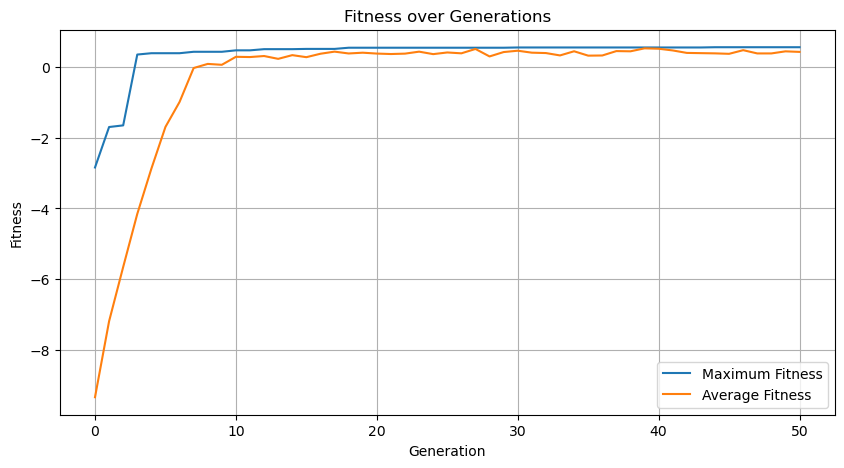

In [6]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Visualize the best Petri net found
output_filename = "viz_petri_nets/best_petri_net.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to viz_petri_nets/best_petri_net.pdf


# Q2

In [8]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox() # Create new empty toolbox

NGEN = 50        # Number of Generations
NUM_RUNS = 10    # Number of runs for boxplots  
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)

crossover_list = [tools.cxTwoPoint, tools.cxOrdered]
mutation_list = [tools.mutUniformInt, tools.mutShuffleIndexes]
selection_list = [tools.selTournament, tools.selRoulette]

combinations = list(itertools.product(crossover_list, mutation_list, selection_list))

In [9]:
def register_specified_variant(toolbox, Crossover, Mutation, Selection):
    toolbox.register("mate", Crossover) 
    if Mutation is tools.mutUniformInt:
        toolbox.register(
            "mutate",
            tools.mutUniformInt,
            low=0,               
            up=NR_PLACES - 1,    
            indpb=INDPB          
        )
    else:
        toolbox.register("mutate", Mutation, indpb=INDPB)

    if Selection == tools.selTournament:
        toolbox.register("select", Selection, tournsize=TOURNSIZE) 
    else:
        toolbox.register("select", Selection)
    return toolbox

def run_genetic_algorithm_q2(toolbox, num_runs=NUM_RUNS):
    max_fitnesses_all_runs = []

    for run in tqdm(range(num_runs), desc="GA Runs", leave=True):

        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                           stats=stats, halloffame=hof, verbose=False)
        
        max_fitness = logbook.select("max")
        max_fitnesses_all_runs.append(max_fitness)

    max_fitnesses_all_runs = np.array(max_fitnesses_all_runs).T

    return max_fitnesses_all_runs

In [10]:
results = {}

for i, comb in enumerate(tqdm(combinations, desc="Evaluating combinations")):
    tbx = base.Toolbox()
    tbx.__dict__.update(copy.deepcopy(toolbox.__dict__))

    tbx = register_specified_variant(tbx, comb[0], comb[1], comb[2])

    print(f"Running combination {i+1}/{len(combinations)}: {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}")
    max_fitnesses_all_runs = run_genetic_algorithm_q2(tbx)
    results[i] = max_fitnesses_all_runs

Evaluating combinations:   0%|          | 0/8 [00:00<?, ?it/s]

Running combination 1/8: cxTwoPoint, mutUniformInt, selTournament


Evaluating combinations:  12%|█▎        | 1/8 [08:33<59:56, 513.74s/it]

Running combination 2/8: cxTwoPoint, mutUniformInt, selRoulette


Evaluating combinations:  25%|██▌       | 2/8 [17:10<51:33, 515.51s/it]

Running combination 3/8: cxTwoPoint, mutShuffleIndexes, selTournament


Evaluating combinations:  38%|███▊      | 3/8 [25:29<42:20, 508.06s/it]

Running combination 4/8: cxTwoPoint, mutShuffleIndexes, selRoulette


Evaluating combinations:  50%|█████     | 4/8 [32:37<31:45, 476.37s/it]

Running combination 5/8: cxOrdered, mutUniformInt, selTournament


Evaluating combinations:  62%|██████▎   | 5/8 [39:55<23:07, 462.51s/it]

Running combination 6/8: cxOrdered, mutUniformInt, selRoulette


Evaluating combinations:  75%|███████▌  | 6/8 [48:00<15:40, 470.07s/it]

Running combination 7/8: cxOrdered, mutShuffleIndexes, selTournament


Evaluating combinations:  88%|████████▊ | 7/8 [1:20:30<15:53, 953.91s/it]

Running combination 8/8: cxOrdered, mutShuffleIndexes, selRoulette


Evaluating combinations: 100%|██████████| 8/8 [1:27:51<00:00, 658.99s/it]


In [11]:
records = []
for i, (cx_op, mut_op, sel_op) in enumerate(combinations):
    arr = results[i]         
    abf_final = arr[-1, :].mean()   
    records.append({
        'Crossover': cx_op.__name__,
        'Mutation' : mut_op.__name__,
        'Selection': sel_op.__name__,
        'ABF'      : round(abf_final, 4)
    })

df_abf = pd.DataFrame(records,
                      columns=['Crossover','Mutation','Selection','ABF'])
print(df_abf)


    Crossover           Mutation      Selection     ABF
0  cxTwoPoint      mutUniformInt  selTournament  0.7169
1  cxTwoPoint      mutUniformInt    selRoulette  0.5773
2  cxTwoPoint  mutShuffleIndexes  selTournament  0.6337
3  cxTwoPoint  mutShuffleIndexes    selRoulette  0.3843
4   cxOrdered      mutUniformInt  selTournament  0.6170
5   cxOrdered      mutUniformInt    selRoulette  0.6429
6   cxOrdered  mutShuffleIndexes  selTournament  0.6336
7   cxOrdered  mutShuffleIndexes    selRoulette  0.5984


In [12]:
def plot_boxplot(results, combinations, title):
    all_final_max_fitnesses = []
    labels = []
    for i, comb in enumerate(combinations):
        max_fitnesses_all_runs = results[i]
        final_max_fitnesses = max_fitnesses_all_runs[-1, :]
        all_final_max_fitnesses.append(final_max_fitnesses)
        labels.append(f"{comb[0].__name__}\n{comb[1].__name__}\n{comb[2].__name__}") 

    plt.figure(figsize=(15, 8)) 
    plt.boxplot(all_final_max_fitnesses, labels=labels, patch_artist=True)
    plt.xlabel("Operator Combination (Crossover, Mutation, Selection)")
    plt.ylabel("Final Maximum Fitness")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout() 
    plt.show()

def plot_ABF(results, combinations, title, a=0, b=NGEN, c=-5, d=1):
    plt.figure(figsize=(12, 6)) 
    generations = None 

    for i, comb in enumerate(combinations):
        max_fitnesses_all_runs = results[i]
        abf = np.mean(max_fitnesses_all_runs, axis=1)
        if generations is None:
             generations = range(len(abf)) 
        label = f"{comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
        plt.plot(generations, abf, label=label)

    plt.xlabel("Generation")
    plt.ylabel("Average Best Fitness (ABF)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
    plt.xlim(a, b)
    plt.ylim(c, d)
    plt.grid(True)
    plt.tight_layout() 
    plt.show()

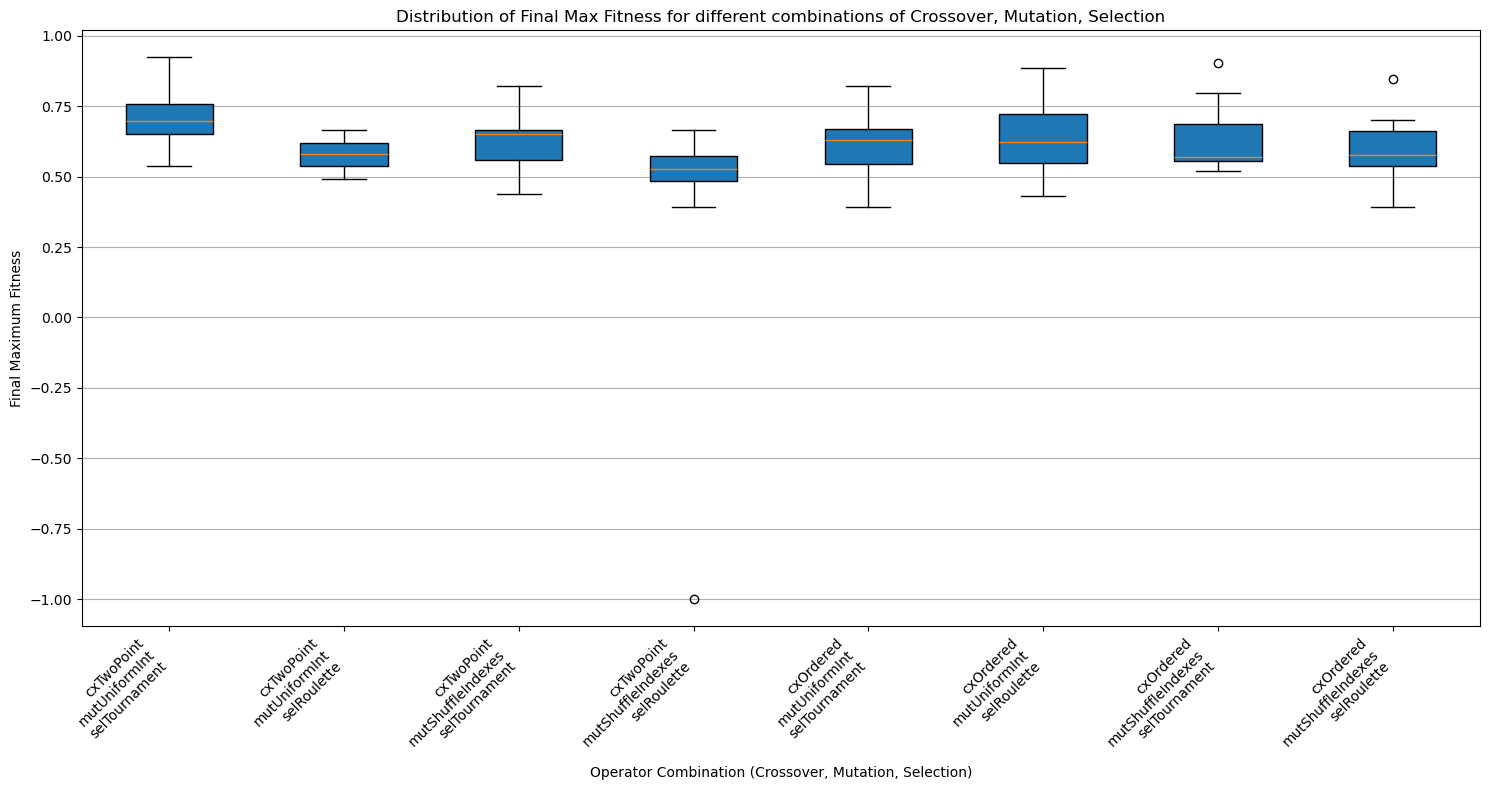

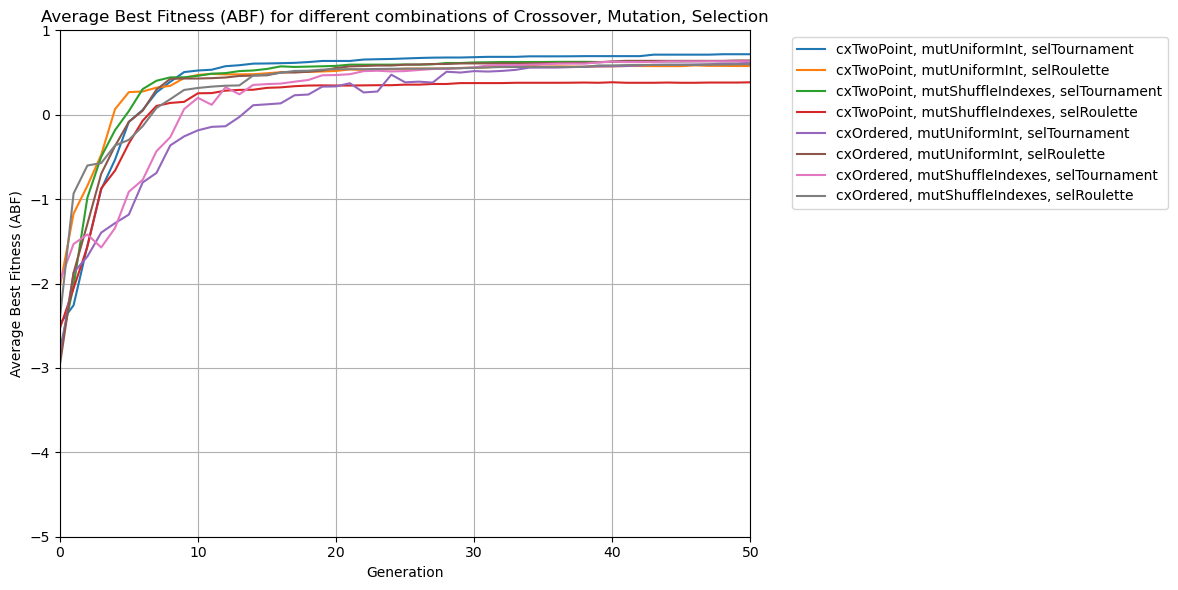

In [13]:
title = f"Distribution of Final Max Fitness for different combinations of Crossover, Mutation, Selection"
plot_boxplot(results, combinations, title)
title = f"Average Best Fitness (ABF) for different combinations of Crossover, Mutation, Selection"
plot_ABF(results, combinations, title)

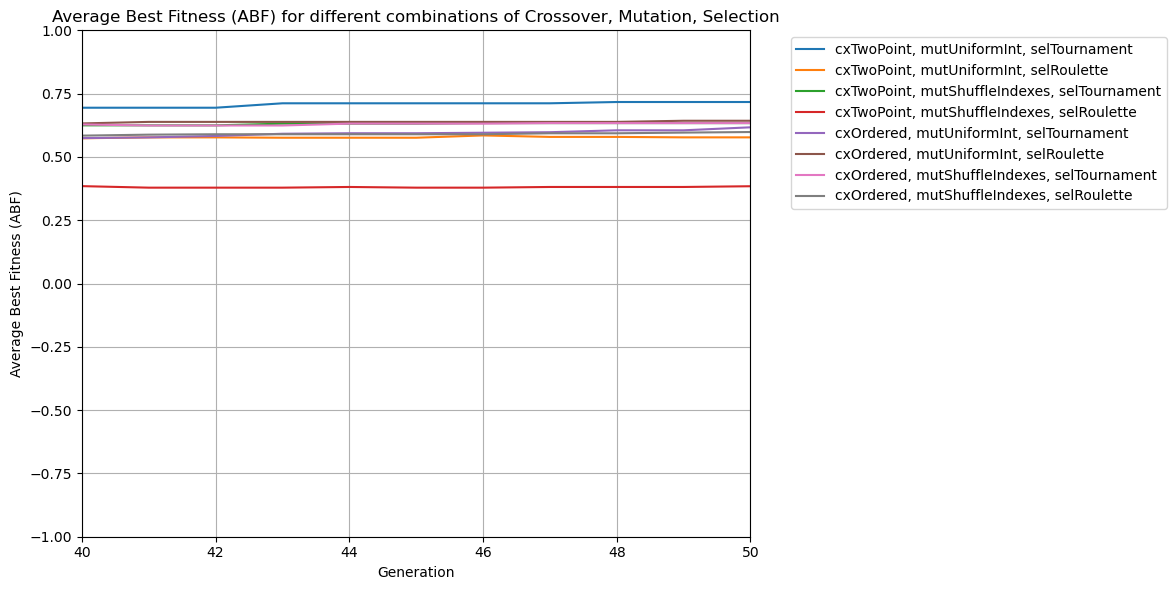

In [33]:
title = f"Average Best Fitness (ABF) for different combinations of Crossover, Mutation, Selection"
plot_ABF(results, combinations, title, 40, 50, -1, 1)

# Q3

In [15]:
NUM_RUNS = 10
NGEN = 50
POP_SIZE = 100

In [16]:
def run_genetic_algorithm(toolbox, cxpb, mutpb, num_runs=NUM_RUNS):
    max_fitnesses_all_runs = []

    for run in tqdm(range(num_runs), desc=f"GA Runs (cxpb={cxpb}, mutpb={mutpb})"):
        
        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        pop, logbook = algorithms.eaSimple(
            pop, toolbox,
            cxpb=cxpb,
            mutpb=mutpb,
            ngen=NGEN,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        # collect the max fitness at each generation
        max_fitnesses_all_runs.append(logbook.select("max"))

    return np.array(max_fitnesses_all_runs).T

crossover_prob_list = [0.2, 0.4, 0.6, 0.8]
mutation_prob_list  = [0.2, 0.4, 0.6, 0.8]
combinations_q3 = list(itertools.product(crossover_prob_list, mutation_prob_list))

best_crossover = tools.cxTwoPoint
best_mutation  = tools.mutUniformInt
best_selection = tools.selTournament

tbx = base.Toolbox()
tbx.__dict__.update(copy.deepcopy(toolbox.__dict__))
tbx = register_specified_variant(tbx,best_crossover,best_mutation, best_selection)
results_q3 = {}
for i, (cxpb, mutpb) in enumerate(
        tqdm(combinations_q3, desc="Evaluating prob combinations")):

    max_fit = run_genetic_algorithm(tbx, cxpb, mutpb)
    results_q3[(cxpb, mutpb)] = max_fit

Evaluating prob combinations: 100%|██████████| 16/16 [5:06:16<00:00, 1148.51s/it]


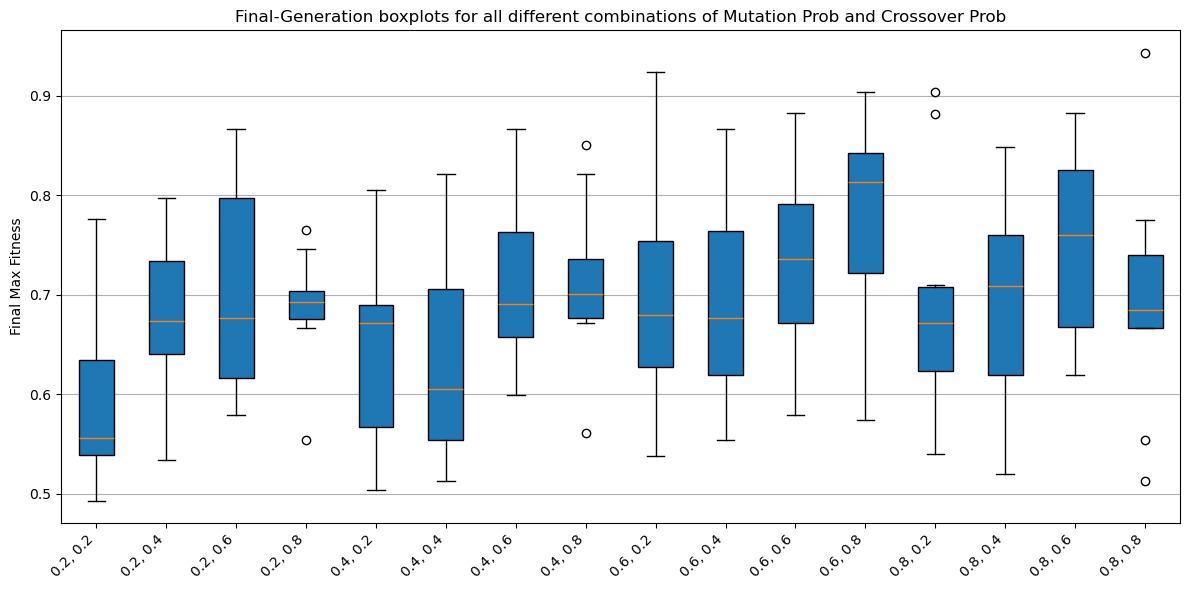

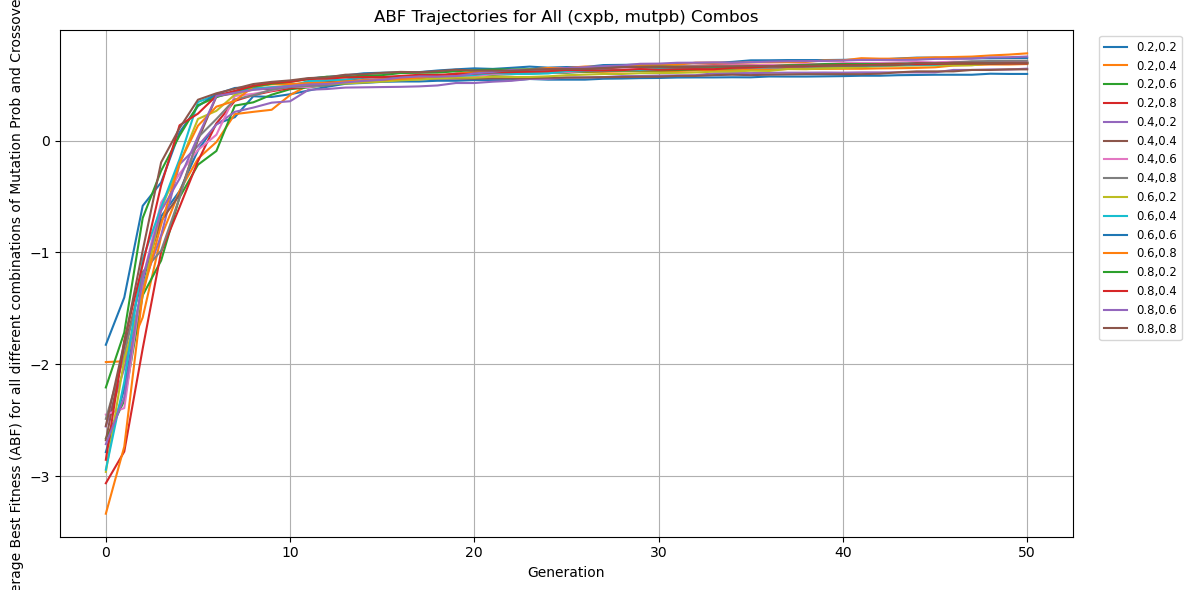

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

labels = []
data_to_plot = []
for (cxpb, mutpb), arr in results_q3.items():
    final_gen = arr[-1, :]
    data_to_plot.append(final_gen)
    labels.append(f"{cxpb:.1f}, {mutpb:.1f}")

ax.boxplot(data_to_plot, patch_artist=True)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel("Final Max Fitness")
ax.set_title("Final‐Generation boxplots for all different combinations of Mutation Prob and Crossover Prob")
ax.grid(axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

for (cxpb, mutpb), arr in results_q3.items():
    abf = arr.mean(axis=1)
    gens = range(len(abf))
    ax.plot(gens, abf, label=f"{cxpb:.1f},{mutpb:.1f}")

ax.set_xlabel("Generation")
ax.set_ylabel("Average Best Fitness (ABF) for all different combinations of Mutation Prob and Crossover Prob")
ax.set_title("ABF Trajectories for All (cxpb, mutpb) Combos")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
ax.grid()
plt.tight_layout()
plt.show()


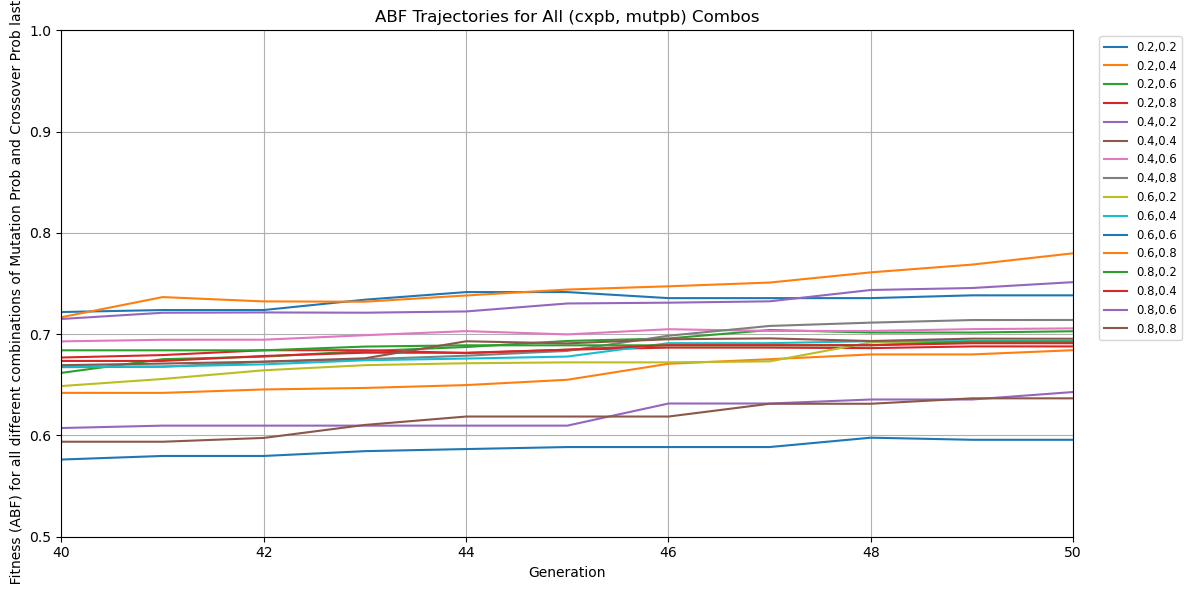

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

for (cxpb, mutpb), arr in results_q3.items():
    abf = arr.mean(axis=1)
    gens = range(len(abf))
    ax.plot(gens, abf, label=f"{cxpb:.1f},{mutpb:.1f}")

ax.set_xlabel("Generation")
ax.set_ylabel("Average Best Fitness (ABF) for all different combinations of Mutation Prob and Crossover Prob last ten generations")
ax.set_title("ABF Trajectories for All (cxpb, mutpb) Combos")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
ax.grid()
plt.xlim(40, 50)
plt.ylim(0.5, 1)
plt.tight_layout()
plt.show()

In [19]:
records = []
for (cxpb, mutpb), arr in results_q3.items():
    avg_best = arr[-1, :].mean()
    records.append({
        'mutation': mutpb,
        'crossover': cxpb,
        'avg_best_fitness': avg_best
    })

df = pd.DataFrame(records)
table = df.pivot(index='mutation',
                 columns='crossover',
                 values='avg_best_fitness')

table.index.name = 'mutation prob'
table.columns.name = 'crossover prob'
print(table.round(4))

crossover prob     0.2     0.4     0.6     0.8
mutation prob                                 
0.2             0.5957  0.6429  0.6919  0.6927
0.4             0.6842  0.6366  0.6931  0.6910
0.6             0.7029  0.7057  0.7383  0.7514
0.8             0.6879  0.7140  0.7799  0.6955


# Q4

In [20]:
def checkSelfLoops():
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for idx, child in enumerate(offspring):
                matrix = list_to_array(child)
                for i in range(matrix.shape[0]):
                    if matrix[i][0] == matrix[i][1]:
                        if matrix[i][1] == NR_PLACES - 1:
                            matrix[i][0] -= 1
                        else:
                            matrix[i][1] += 1
                offspring[idx][:] = matrix.flatten().tolist()
            return offspring
        return wrapper
    return decorator

def checkBackwardsVisibleLoops():
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for idx, child in enumerate(offspring):
                matrix = list_to_array(child)
                for i in range(matrix.shape[0]):
                    if matrix[i][0] > matrix[i][1]:
                        matrix[i][0], matrix[i][1] = matrix[i][1], matrix[i][0]
                offspring[idx][:] = matrix.flatten().tolist()
            return offspring
        return wrapper
    return decorator

In [21]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 500        # Number of Generations
POP_SIZE = 100   # Population size
CXPB = 0.6       # Crossover Probability
MUTPB = 0.8      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) 
toolbox.register("mate", tools.cxTwoPoint) 
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB) 
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  

toolbox.decorate("mate", checkSelfLoops()) 
toolbox.decorate("mate", checkBackwardsVisibleLoops()) 
toolbox.decorate("mutate", checkSelfLoops())
toolbox.decorate("mutate", checkBackwardsVisibleLoops())

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) 
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)



gen	nevals	max	avg    	min	std    
0  	100   	-2 	-10.075	-17	3.08496
1  	86    	0.659158	-1.0689	-11	2.60287
2  	89    	0.679826	0.162071	-1 	0.427764
3  	89    	0.679826	0.255062	-1 	0.441868
4  	96    	0.679826	0.347537	-1 	0.418583
5  	93    	0.679826	0.44738 	-1 	0.357505
6  	92    	0.671658	0.514765	-1 	0.329698
7  	92    	0.703198	0.540996	-1 	0.332167
8  	92    	0.716694	0.577979	-1 	0.28821 
9  	87    	0.716694	0.571553	-1 	0.331232
10 	92    	0.754461	0.503857	-1 	0.427777
11 	96    	0.754461	0.546718	-1 	0.372865
12 	90    	0.754461	0.561491	-1 	0.37236 
13 	94    	0.725769	0.535895	-1 	0.403104
14 	93    	0.754461	0.600065	-1 	0.297342
15 	87    	0.760535	0.54434 	-1 	0.430559
16 	94    	0.760535	0.552299	-1 	0.436192
17 	94    	0.760535	0.605   	-1 	0.341775
18 	94    	0.760535	0.502928	-1 	0.535492
19 	89    	0.760535	0.48961 	-1 	0.558077
20 	89    	0.760535	0.554738	-1 	0.4726  
21 	88    	0.760535	0.503398	-1 	0.561492
22 	91    	0.760535	0.52639 	-1 	0.543753
23 	95  

### Results Q4 for Q5 (using Tool Decorators)

In [22]:
best_ind = hof[0]
# print("\nBest Individual:")
# print(best_ind)
# best_matrix = list_to_array(best_ind) 
# print(best_matrix)
print(f"Fitness: {best_ind.fitness.values[0]}")

# best_matrix = list_to_array(best_ind) 
# print("\nBest Matrix:")
# print(best_matrix)

Fitness: 0.7605353633294808


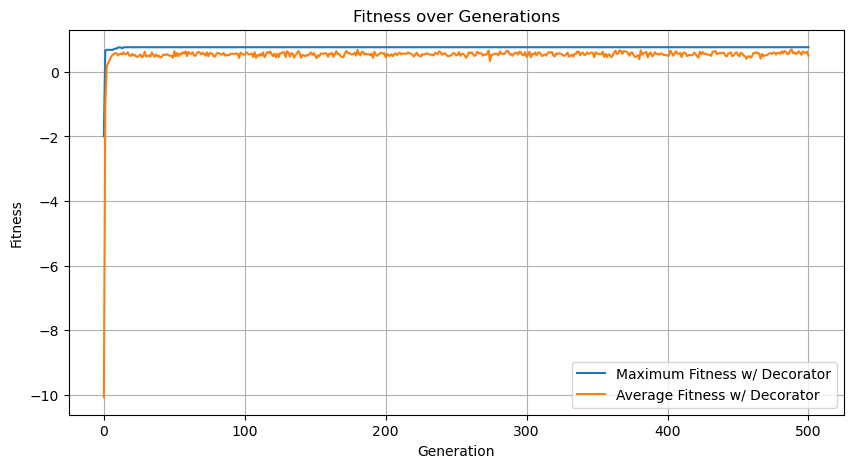

In [23]:
gen_q4 = logbook.select("gen")
max_fitness_q4 = logbook.select("max")
avg_fitness_q4 = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen_q4, max_fitness_q4, label="Maximum Fitness w/ Decorator")
plt.plot(gen_q4, avg_fitness_q4, label="Average Fitness w/ Decorator") 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
output_filename = "viz_petri_nets/best_petri_net_decorator.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to viz_petri_nets/best_petri_net_decorator.pdf


# Q5

### Results Q4 for Q5 (without Tool Decorators / equal to Q1 with optimal parameters from Q2/Q3)

In [25]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 500        # Number of Generations
POP_SIZE = 100   # Population size
CXPB = 0.6       # Crossover Probability
MUTPB = 0.8      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) 
toolbox.register("mate", tools.cxTwoPoint) 
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB)
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) 
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	max     	avg     	min	std    
0  	100   	-3.77178	-9.88603	-16	2.71314
1  	89    	-2.77262	-7.54988	-14	2.34283
2  	91    	-1.65324	-5.68343	-12	1.95633
3  	90    	-0.703243	-4.13331	-11	1.49167
4  	92    	-0.529864	-3.10136	-6.50723	1.10913
5  	92    	0.327051 	-2.74847	-7.6332 	1.44217
6  	89    	0.470136 	-2.23535	-7      	1.44786
7  	95    	0.470136 	-1.81813	-6      	1.28995
8  	90    	0.553636 	-1.1168 	-5.70628	1.05749
9  	92    	0.553636 	-0.779459	-4      	1.07894
10 	93    	0.553636 	-0.500694	-4      	1.00751
11 	93    	0.553636 	-0.500364	-5.6332 	1.03007
12 	86    	0.553636 	-0.260483	-4      	0.950135
13 	91    	0.557968 	-0.0758844	-3.77262	0.857664
14 	85    	0.553636 	-0.061638 	-5      	1.08257 
15 	88    	0.557968 	-0.258229 	-4      	1.15245 
16 	91    	0.557968 	-0.13834  	-3.49957	0.963085
17 	91    	0.557968 	-0.190883 	-2.6332 	0.880134
18 	98    	0.566136 	-0.141849 	-3.6332 	0.856195
19 	95    	0.566136 	-0.17163  	-3.51824	0.987133
20 	95    	0.557

In [26]:
best_ind = hof[0]
# print("\nBest Individual:")
# print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

best_matrix = list_to_array(best_ind)
# print("\nBest Matrix:")
# print(best_matrix)

Fitness: 0.9833333333333334


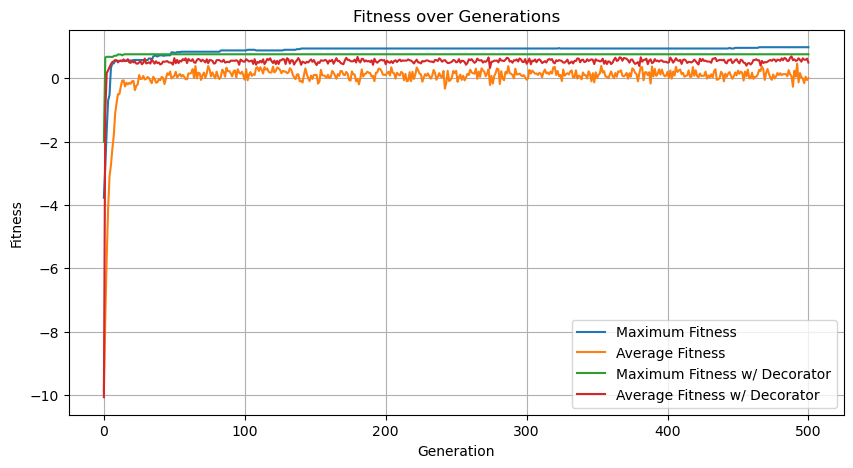

In [27]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.plot(gen_q4, max_fitness_q4, label="Maximum Fitness w/ Decorator")
plt.plot(gen_q4, avg_fitness_q4, label="Average Fitness w/ Decorator") 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
output_filename = "viz_petri_nets/best_petri_net_Q1_optimal_param.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to viz_petri_nets/best_petri_net_Q1_optimal_param.pdf


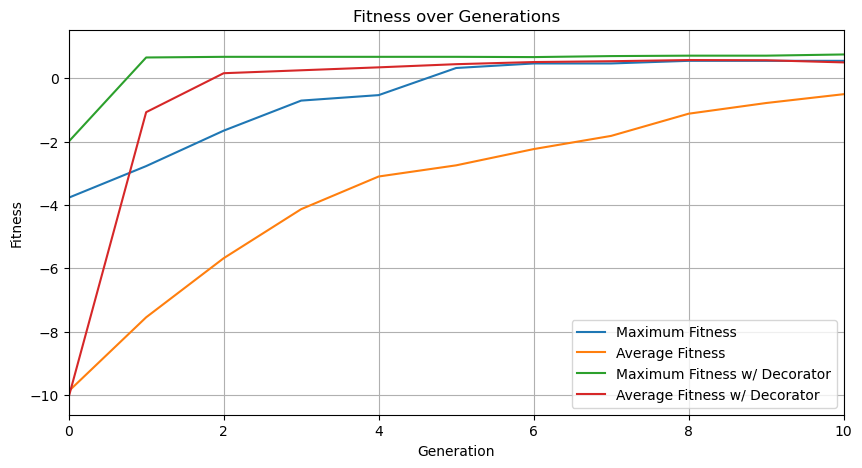

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.plot(gen_q4, max_fitness_q4, label="Maximum Fitness w/ Decorator")
plt.plot(gen_q4, avg_fitness_q4, label="Average Fitness w/ Decorator") 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.xlim(0, 10)
plt.grid(True)
plt.show()

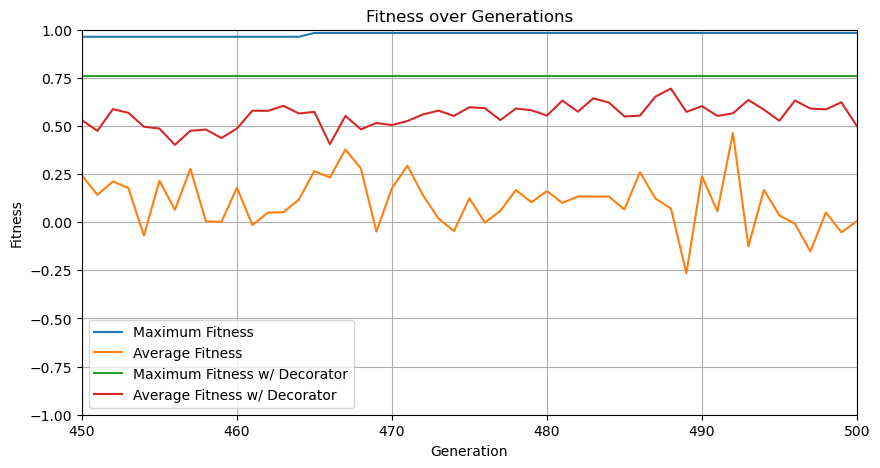

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.plot(gen_q4, max_fitness_q4, label="Maximum Fitness w/ Decorator")
plt.plot(gen_q4, avg_fitness_q4, label="Average Fitness w/ Decorator") 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.xlim(450, 500)
plt.ylim(-1, 1)
plt.grid(True)
plt.show()